# Hamiltonian Descent for  <img src="https://upload.wikimedia.org/wikipedia/commons/1/10/PyTorch_logo_icon.svg" style="height:0.75em"/>PyTorch

---

## Setup

In [450]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [451]:
def V(x: torch.tensor):
    return 2. * torch.linalg.norm(x)**2

def minimize(
    V: Callable, 
    x: torch.tensor, 
    optimizer: torch.optim.Optimizer, 
    iters: int=100):

    V_hist = []
    x_hist = []

    for _ in range(iters):
        V_x = V(x)
        V_hist.append(V_x.detach())
        x_hist.append(x.detach())
        optimizer.zero_grad()
        V_x.backward()
        optimizer.step()
        
    return V_hist, x_hist

## Basic Optimizer Usage

---

We use the function 
$$
    f: \mathbb R^F \to \mathbb R , \ \ x\mapsto 2\cdot \vert \vert x \vert \vert^2\, ,
$$
with gradient:
$$
    \nabla_x f(x) = 4x
$$

### Getting Gradients

In [452]:
x = torch.ones(3, requires_grad=True)
V_x = V(x)
V_x.backward()
print(x.grad)

tensor([4.0000, 4.0000, 4.0000])


### Using Gradient Descent

We expect $x$ to be optimized by 
$$
    x\leftarrow x - 0.01\cdot \nabla_x f(x) = (1,\ 1,\ 1) - 0.01 \cdot (4,\ 4,\ 4) = (0.96,\ 0.96,\ 0.96)\, .
$$

In [453]:
x = torch.ones(3, requires_grad=True)
V_x = V(x)

optimizer = torch.optim.SGD([x], 0.01)
optimizer.zero_grad()
V_x.backward()
optimizer.step()
print(x)

tensor([0.9600, 0.9600, 0.9600], requires_grad=True)


In [454]:
x = torch.ones(3, requires_grad=True)
optimizer = torch.optim.SGD([x], 0.01)
V_hist, x_hist = minimize(V, x, optimizer)

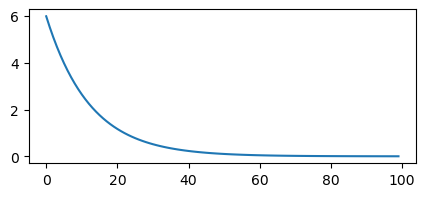

In [455]:
fig = plt.figure(figsize=(5, 2))
plt.plot(V_hist)
plt.show()

## Hamiltonian Descent

---

In [456]:
## Initializing Position
x = torch.ones(3)
x.requires_grad_(True)

## Initializing Momentum Variables
p = torch.normal(torch.zeros_like(x), torch.ones_like(x)).requires_grad_(True)

In [457]:
## Kinetic Energy Gradient:
def T(p: torch.tensor):
    return torch.linalg.norm(p)**2 / 2.

In [458]:
def hamiltonian_descent(
    V: Callable, 
    T: Callable,
    x: torch.tensor, 
    p: torch.tensor,
    eps: float=0.5,
    gamma: float=10.,
    iters: int=100):

    delta = (1. + gamma*eps)**(-1.)
    eps_delta = eps*delta

    print(f"delta: {delta}")

    V_hist = []
    x_hist = []
    x_grad_hist = []
    # params = [x]
    # momenta = [p]

    for _ in range(iters):

        V_x = V(x)
        T_p = T(p)
        T_p.backward()
        V_x.backward()

        x_grad = x.grad
        p_grad = p.grad
        p.data.mul_(delta).add_(-eps_delta*x_grad)
        x.data.add_(eps*p_grad)

        ## Standard gradient descent would be:
        # x.data.add_(-1.*eps*x_grad)

        V_hist.append(V_x.detach().clone().numpy())
        x_hist.append(x.detach().clone().numpy())
        x_grad_hist.append(x_grad.detach().clone().numpy())

        x.grad.zero_()
        p.grad.zero_()

    return V_hist, x_hist, x_grad_hist

In [459]:
V_hist, x_hist, x_grad_hist = hamiltonian_descent(V, T, x, p, iters=100)

delta: 0.16666666666666666


In [460]:
# np.all([np.allclose(4*x, g) for x, g in zip(x_hist[:-1], x_grad_hist[1:])])

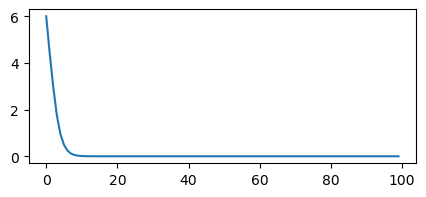

In [461]:
fig = plt.figure(figsize=(5, 2))
plt.plot(V_hist)
plt.show()